# DCGAN + Discriminador con Backbone Preentrenado (FashionMNIST)

Este cuadernillo local implementa una **DCGAN** donde el discriminador puede ser:
- Conv clásico (baseline DCGAN), o
- Un backbone **preentrenado** de `torchvision` (ResNet18, MobileNetV2, EfficientNet-B0, VGG11-BN).

Se entrena sobre **FashionMNIST** (con MNIST/KMNIST como respaldo). No requiere Google Colab.

## Dependencias

In [1]:
# Instala en tu entorno local (no Colab):
# pip install -r requirements_dcgan.txt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils as vutils, models
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib para mejores visualizaciones
plt.style.use('default')
sns.set_palette("husl")

print("✅ PyTorch version:", torch.__version__)
print("✅ Torchvision version:", torch.version.__version__ if hasattr(torch.version, '__version__') else "N/A")

# Verificar dispositivo disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ CUDA disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Metal Performance Shaders (MPS) disponible")
else:
    device = torch.device("cpu")
    print("⚠️  Usando CPU (recomendado usar GPU para mejor rendimiento)")

print(f"🚀 Dispositivo seleccionado: {device}")

# Verificar número de workers disponibles
num_workers_max = min(8, os.cpu_count() or 1)
print(f"💾 Workers disponibles: {num_workers_max}")

device

✅ PyTorch version: 2.7.0+cu128
✅ Torchvision version: 2.7.0+cu128
✅ CUDA disponible: NVIDIA GeForce RTX 3050 6GB Laptop GPU
   Memoria GPU: 6.0 GB
🚀 Dispositivo seleccionado: cuda
💾 Workers disponibles: 8


device(type='cuda')

## Configuración

In [5]:
CFG = {
    # Datos
    "dataset": "fashion_mnist",     # "fashion_mnist" | "mnist" | "kmnist" | "cifar10"
    "data_dir": "./data",
    "out_dir": "./runs/dcgan_pretrained_nb",
    
    # Entrenamiento
    "epochs": 3,  # Reducido para prueba rápida
    "batch_size": 128,
    "num_workers": 4,
    
    # Arquitectura
    "z_dim": 100,
    "image_size": 64,
    "g_channels": 64,
    "d_channels": 64,
    "disc": "resnet18",             # "dcgan" | "resnet18" | "mobilenet_v2" | "efficientnet_b0" | "vgg11_bn"
    "use_pretrained": True,
    "dropout_rate": 0.2,            # Para discriminador
    
    # Optimización
    "lr_g": 2e-4,
    "lr_d": 2e-4,
    "beta1": 0.5,
    "beta2": 0.999,
    "weight_decay": 1e-5,
    "label_smoothing": True,
    "gradient_penalty": False,      # WGAN-GP style
    "spectral_norm": False,         # Normalización espectral
    
    # Regularización y estabilidad
    "real_label_smoothing": 0.9,    # Suavizado para etiquetas reales
    "fake_label_smoothing": 0.1,    # Suavizado para etiquetas falsas
    "noise_std": 0.1,               # Ruido en inputs del discriminador
    
    # Logging y guardado
    "seed": 42,
    "log_every": 50,
    "save_every": 2,                # Guardar checkpoints cada 2 épocas para prueba
    "eval_every": 1,                # Evaluación cada época para prueba
    "num_eval_samples": 64,         # Muestras para evaluación
    
    # Visualización
    "plot_losses": True,
    "plot_gradients": True,
    "show_samples_during_training": True,
}

# Crear directorios necesarios
output_dir = Path(CFG["out_dir"])
samples_dir = output_dir / "samples"
checkpoints_dir = output_dir / "checkpoints"
logs_dir = output_dir / "logs"

for dir_path in [samples_dir, checkpoints_dir, logs_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("📁 Directorios creados:")
print(f"   Salida: {output_dir}")
print(f"   Muestras: {samples_dir}")
print(f"   Checkpoints: {checkpoints_dir}")
print(f"   Logs: {logs_dir}")

# Validar configuración
if CFG["disc"] not in ["dcgan", "resnet18", "mobilenet_v2", "efficientnet_b0", "vgg11_bn"]:
    raise ValueError(f"Discriminador no soportado: {CFG['disc']}")

if CFG["dataset"] not in ["fashion_mnist", "mnist", "kmnist", "cifar10"]:
    raise ValueError(f"Dataset no soportado: {CFG['dataset']}")

print("✅ Configuración validada correctamente")
print(f"🎯 Entrenando con discriminador: {CFG['disc']}")
print(f"📊 Dataset: {CFG['dataset']}")
print(f"🔧 Usando pesos pretrained: {CFG['use_pretrained']}")
print(f"⏱️  Épocas configuradas: {CFG['epochs']} (prueba rápida)")

CFG

📁 Directorios creados:
   Salida: runs\dcgan_pretrained_nb
   Muestras: runs\dcgan_pretrained_nb\samples
   Checkpoints: runs\dcgan_pretrained_nb\checkpoints
   Logs: runs\dcgan_pretrained_nb\logs
✅ Configuración validada correctamente
🎯 Entrenando con discriminador: resnet18
📊 Dataset: fashion_mnist
🔧 Usando pesos pretrained: True
⏱️  Épocas configuradas: 3 (prueba rápida)


{'dataset': 'fashion_mnist',
 'data_dir': './data',
 'out_dir': './runs/dcgan_pretrained_nb',
 'epochs': 3,
 'batch_size': 128,
 'num_workers': 4,
 'z_dim': 100,
 'image_size': 64,
 'g_channels': 64,
 'd_channels': 64,
 'disc': 'resnet18',
 'use_pretrained': True,
 'dropout_rate': 0.2,
 'lr_g': 0.0002,
 'lr_d': 0.0002,
 'beta1': 0.5,
 'beta2': 0.999,
 'weight_decay': 1e-05,
 'label_smoothing': True,
 'gradient_penalty': False,
 'spectral_norm': False,
 'real_label_smoothing': 0.9,
 'fake_label_smoothing': 0.1,
 'noise_std': 0.1,
 'seed': 42,
 'log_every': 50,
 'save_every': 2,
 'eval_every': 1,
 'num_eval_samples': 64,
 'plot_losses': True,
 'plot_gradients': True,
 'show_samples_during_training': True}

## Modelos y utilidades

In [3]:
import random
from typing import Tuple, Optional

def set_seed(seed: int = 42):
    """Establecer semilla para reproducibilidad"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def weights_init_dcgan(m):
    """Inicialización de pesos DCGAN estándar"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def weights_init_xavier(m):
    """Inicialización Xavier/Glorot para redes profundas"""
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def denorm(x):
    """Desnormalizar de [-1,1] a [0,1]"""
    return x.add(1).div(2).clamp(0, 1)

def add_noise(x, noise_std=0.1):
    """Agregar ruido gaussiano para regularización"""
    if noise_std > 0:
        return x + torch.randn_like(x) * noise_std
    return x

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64, out_size=64):
        super().__init__()
        self.z_dim = z_dim
        self.img_channels = img_channels
        self.feature_g = feature_g
        
        # Arquitectura DCGAN mejorada
        self.net = nn.Sequential(
            # Input: z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            # 4x4
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            # 8x8
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            # 16x16
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            # 32x32
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # 64x64
        )
        
    def forward(self, z):
        return self.net(z)
    
    def generate_samples(self, num_samples=16, device='cpu'):
        """Generar muestras aleatorias"""
        with torch.no_grad():
            z = torch.randn(num_samples, self.z_dim, 1, 1, device=device)
            return self(z)

class DiscriminatorDCGAN(nn.Module):
    def __init__(self, img_channels=3, feature_d=64, dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate
        
        self.net = nn.Sequential(
            # 64x64
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            # 32x32
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            # 16x16
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            # 8x8
            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            # 4x4
            nn.Conv2d(feature_d * 8, 1, 4, 1, 0, bias=False),
            # 1x1
        )
        
    def forward(self, x):
        output = self.net(x)
        return output.view(x.size(0), -1).squeeze(1)

class DiscriminatorPretrained(nn.Module):
    def __init__(self, backbone_name="resnet18", pretrained=True, dropout_rate=0.2):
        super().__init__()
        self.backbone_name = backbone_name.lower()
        self.pretrained = pretrained
        self.dropout_rate = dropout_rate
        
        self.backbone, feat_dim = self._make_backbone(self.backbone_name, pretrained)
        
        # Cabezal clasificador mejorado
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(feat_dim // 2, 1)
        )
        
    def _make_backbone(self, name, pretrained):
        weights = None
        try:
            if pretrained:
                if name == "resnet18":
                    weights = models.ResNet18_Weights.DEFAULT
                elif name == "mobilenet_v2":
                    weights = models.MobileNet_V2_Weights.DEFAULT
                elif name == "efficientnet_b0":
                    weights = models.EfficientNet_B0_Weights.DEFAULT
                elif name == "vgg11_bn":
                    weights = models.VGG11_BN_Weights.DEFAULT
        except Exception as e:
            print(f"⚠️  No se pudieron cargar pesos pretrained: {e}")
            weights = None
            
        if name == "resnet18":
            m = models.resnet18(weights=weights)
            feat_dim = m.fc.in_features
            m.fc = nn.Identity()
            return m, feat_dim
        elif name == "mobilenet_v2":
            m = models.mobilenet_v2(weights=weights)
            feat_dim = m.classifier[-1].in_features
            m.classifier = nn.Identity()
            return m, feat_dim
        elif name == "efficientnet_b0":
            m = models.efficientnet_b0(weights=weights)
            feat_dim = m.classifier[-1].in_features
            m.classifier = nn.Identity()
            return m, feat_dim
        elif name == "vgg11_bn":
            m = models.vgg11_bn(weights=weights)
            feat_dim = 512
            m.classifier = nn.Identity()
            return m, feat_dim
        else:
            raise ValueError(f"Backbone no soportado: {name}")
            
    def forward(self, x):
        feat = self.backbone(x)
        if isinstance(feat, torch.Tensor) and feat.dim() > 2:
            feat = torch.flatten(feat, 1)
        return self.classifier(feat).squeeze(1)

# Función para contar parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Clases de modelos definidas")
print("🔧 Funciones utilitarias disponibles")
print("📊 Mejoras incluidas:")
print("   - Dropout para regularización")
print("   - Inicialización Xavier alternativa")
print("   - Ruido gaussiano opcional")
print("   - Cabezal clasificador mejorado para discriminador pretrained")
print("   - Método para generar muestras")
print("   - Contador de parámetros")

✅ Clases de modelos definidas
🔧 Funciones utilitarias disponibles
📊 Mejoras incluidas:
   - Dropout para regularización
   - Inicialización Xavier alternativa
   - Ruido gaussiano opcional
   - Cabezal clasificador mejorado para discriminador pretrained
   - Método para generar muestras
   - Contador de parámetros


## Datos

📥 Cargando dataset: fashion_mnist
✅ Dataset cargado exitosamente
📊 Tamaño del dataset: 60,000 imágenes
🔢 Número de batches: 468
📐 Forma de batch: torch.Size([128, 3, 64, 64])
📐 Forma de batch: torch.Size([128, 3, 64, 64])

📈 Estadísticas del batch:
   Min: -1.000
   Max: 1.000
   Media: -0.445
   Std: 0.666

🖼️  Mostrando muestras del dataset...

📈 Estadísticas del batch:
   Min: -1.000
   Max: 1.000
   Media: -0.445
   Std: 0.666

🖼️  Mostrando muestras del dataset...


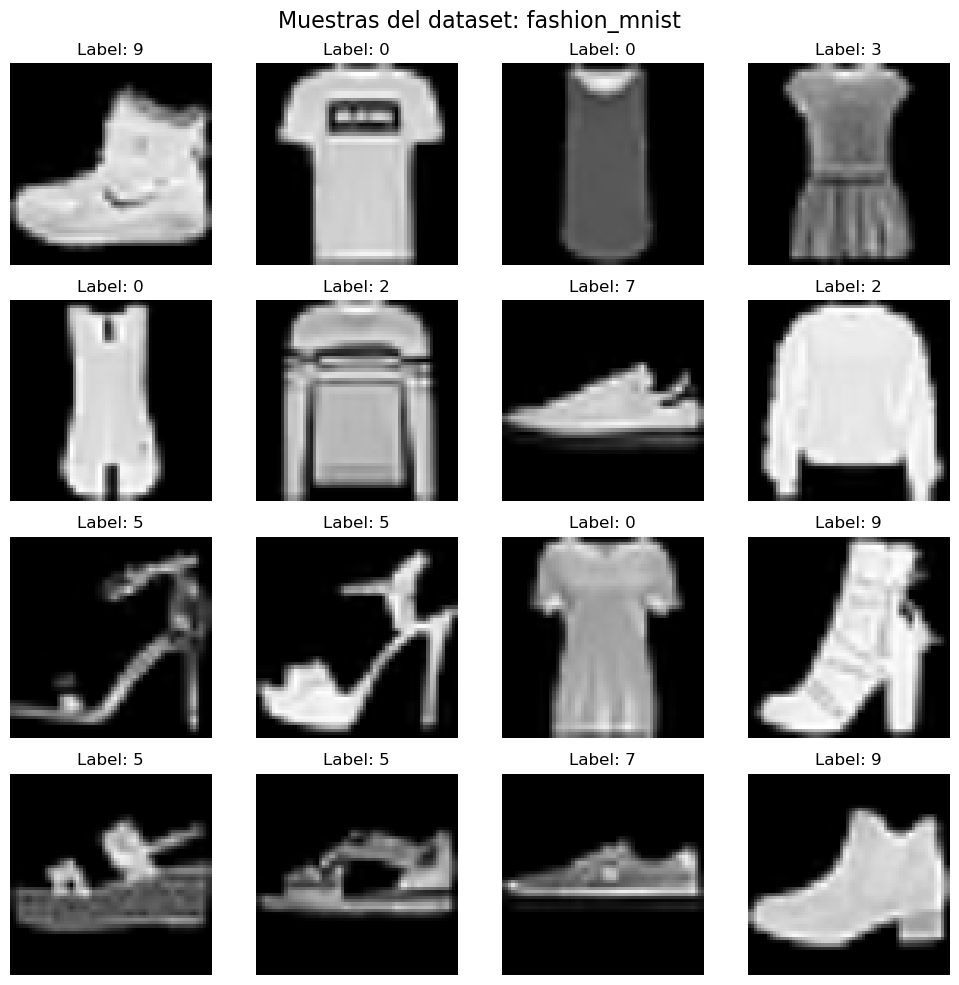

In [4]:
def get_transforms(dataset_name, image_size=64):
    """Obtener transformaciones específicas para cada dataset"""
    if dataset_name.lower() == "cifar10":
        # CIFAR-10 ya es en color, solo redimensionar y normalizar
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    else:
        # Para datasets en escala de grises (MNIST, FashionMNIST, KMNIST)
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.Grayscale(num_output_channels=3),  # Convertir a 3 canales
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    return transform

def get_dataset(name, data_dir="./data", image_size=64):
    """Obtener dataset con transformaciones apropiadas"""
    name = name.lower()
    transform = get_transforms(name, image_size)
    
    if name in ["fashion_mnist", "fmnist", "fashion"]:
        return datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
    elif name == "mnist":
        return datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    elif name == "kmnist":
        return datasets.KMNIST(root=data_dir, train=True, download=True, transform=transform)
    elif name == "cifar10":
        return datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    else:
        raise ValueError(f"Dataset no soportado: {name}")

def show_dataset_samples(dataset, num_samples=16):
    """Mostrar muestras del dataset"""
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f'Muestras del dataset: {CFG["dataset"]}', fontsize=16)
    
    for i in range(num_samples):
        img, label = dataset[i]
        img_denorm = denorm(img)
        
        ax = axes[i // 4, i % 4]
        ax.imshow(img_denorm.permute(1, 2, 0))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Cargar dataset
print(f"📥 Cargando dataset: {CFG['dataset']}")
train_ds = get_dataset(CFG["dataset"], CFG["data_dir"], CFG["image_size"])

# Crear DataLoader
loader = DataLoader(
    train_ds, 
    batch_size=CFG["batch_size"], 
    shuffle=True, 
    num_workers=CFG["num_workers"], 
    drop_last=True,
    pin_memory=True if device.type == "cuda" else False
)

print(f"✅ Dataset cargado exitosamente")
print(f"📊 Tamaño del dataset: {len(train_ds):,} imágenes")
print(f"🔢 Número de batches: {len(loader):,}")
print(f"📐 Forma de batch: {next(iter(loader))[0].shape}")

# Mostrar estadísticas del dataset
sample_batch = next(iter(loader))[0]
print(f"\n📈 Estadísticas del batch:")
print(f"   Min: {sample_batch.min().item():.3f}")
print(f"   Max: {sample_batch.max().item():.3f}")
print(f"   Media: {sample_batch.mean().item():.3f}")
print(f"   Std: {sample_batch.std().item():.3f}")

# Mostrar muestras del dataset
print(f"\n🖼️  Mostrando muestras del dataset...")
show_dataset_samples(train_ds, 16)

## Entrenamiento

🏗️  Inicializando modelos...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\diego/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:14<00:00, 3.17MB/s]



🔧 Usando discriminador pretrained: resnet18
⚖️  Inicializando pesos...

📊 Información de modelos:
   Generador: 3,576,704 parámetros
   Discriminador: 11,308,097 parámetros
   Total: 14,884,801 parámetros
🎯 Etiquetas configuradas: real=0.9, fake=0.1
🚀 Iniciando entrenamiento...


Época 1/3:   0%|          | 0/468 [00:00<?, ?it/s]


📊 Época 1/3 completada:
   Pérdida D: 0.3734
   Pérdida G: 2.1353
   Tiempo: 80.53s
   Score D(real): 0.311
   Score D(fake): 0.424
   Score D(real): 0.311
   Score D(fake): 0.424


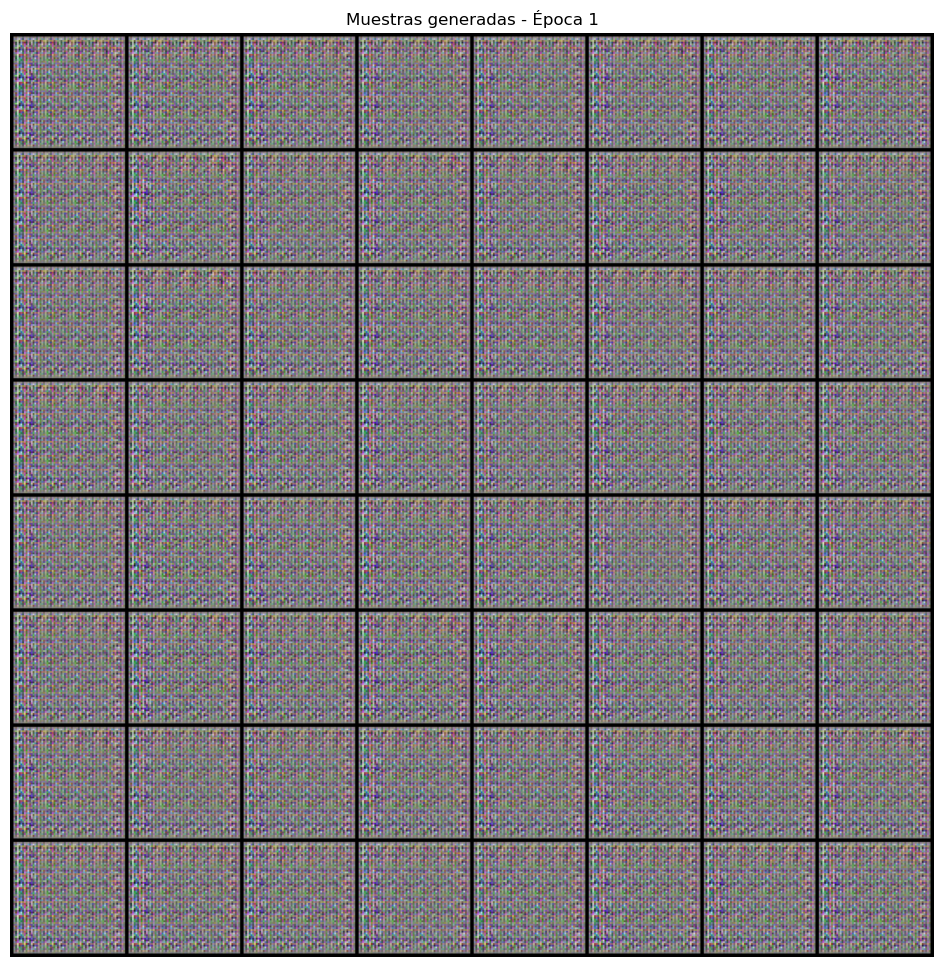

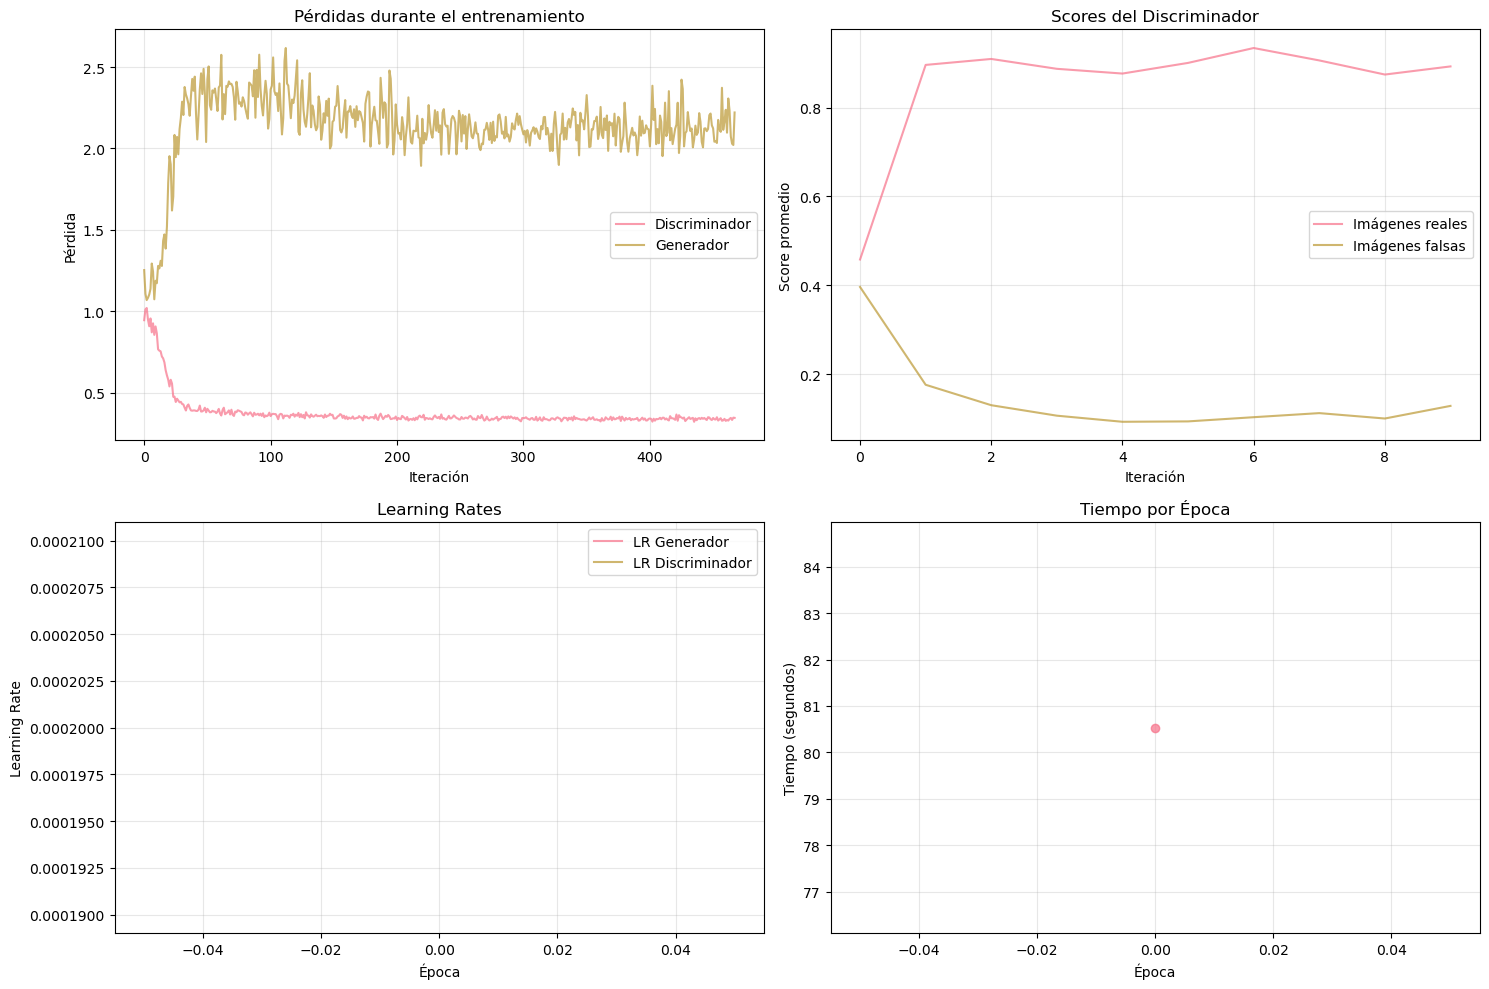

Época 2/3:   0%|          | 0/468 [00:00<?, ?it/s]


📊 Época 2/3 completada:
   Pérdida D: 0.3351
   Pérdida G: 2.1120
   Tiempo: 87.69s
   Score D(real): 0.404
   Score D(fake): 0.372
   Score D(real): 0.404
   Score D(fake): 0.372


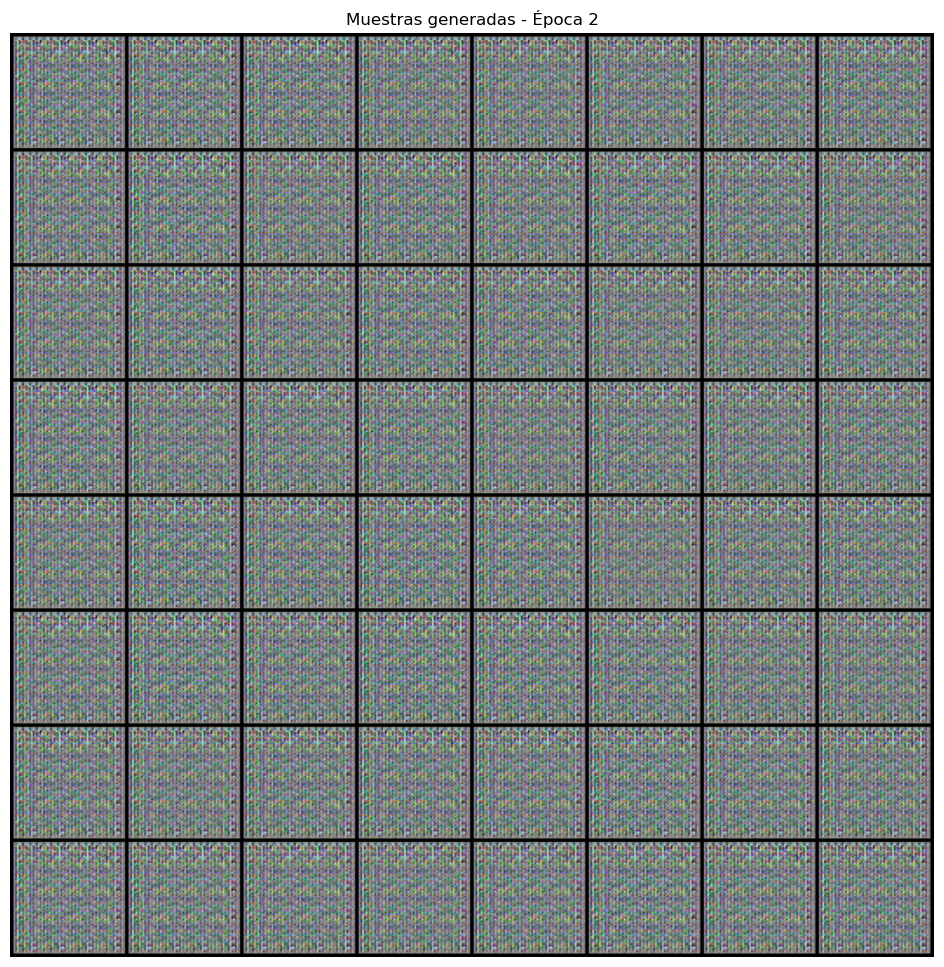

💾 Checkpoint guardado: epoch_002.pt


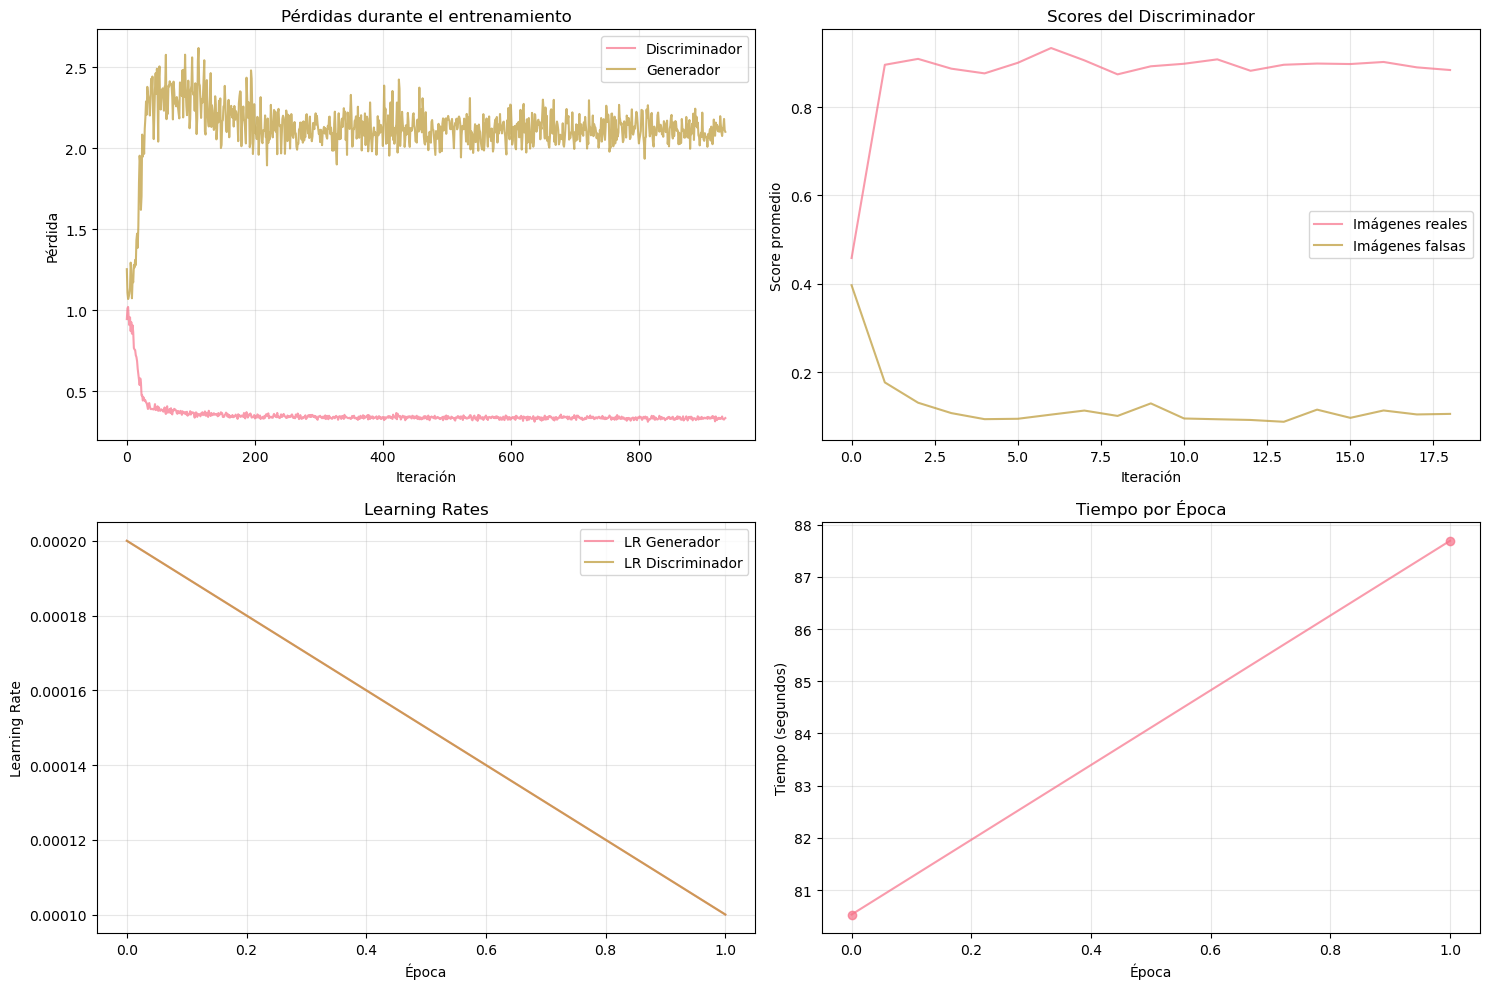

Época 3/3:   0%|          | 0/468 [00:00<?, ?it/s]


📊 Época 3/3 completada:
   Pérdida D: 0.3324
   Pérdida G: 2.1094
   Tiempo: 81.79s
   Score D(real): 0.359
   Score D(fake): 0.352
   Score D(real): 0.359
   Score D(fake): 0.352


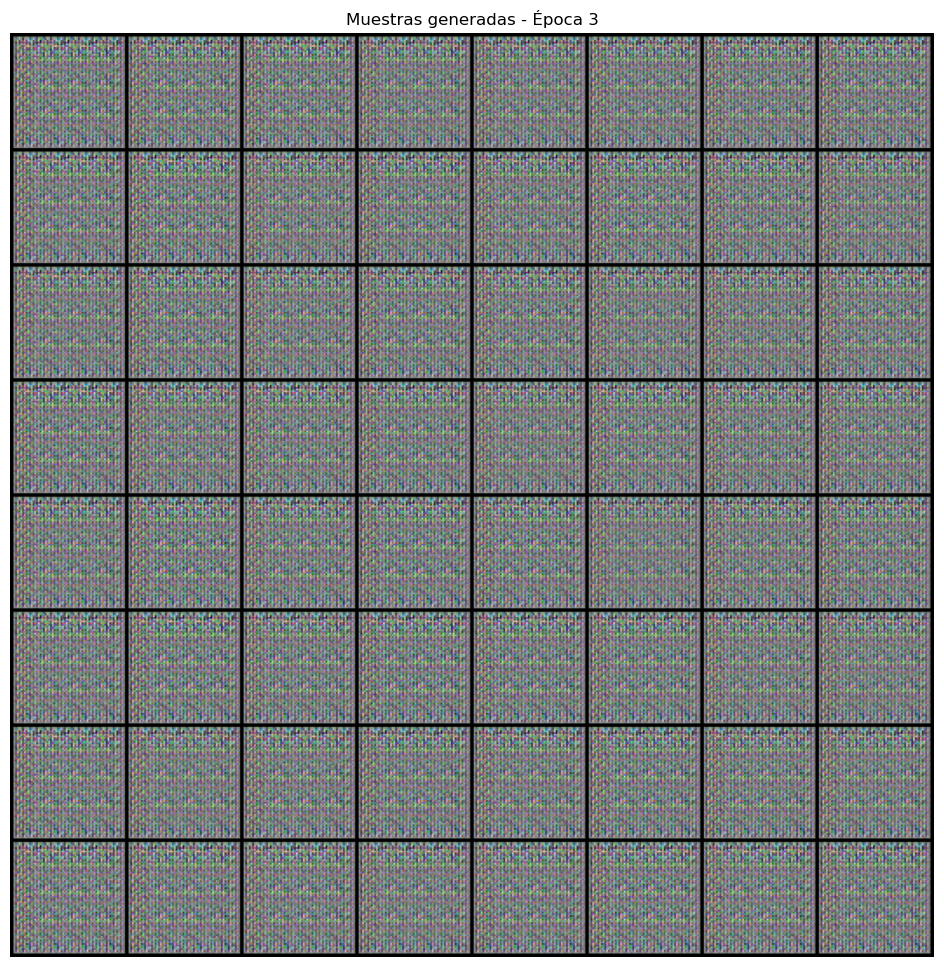

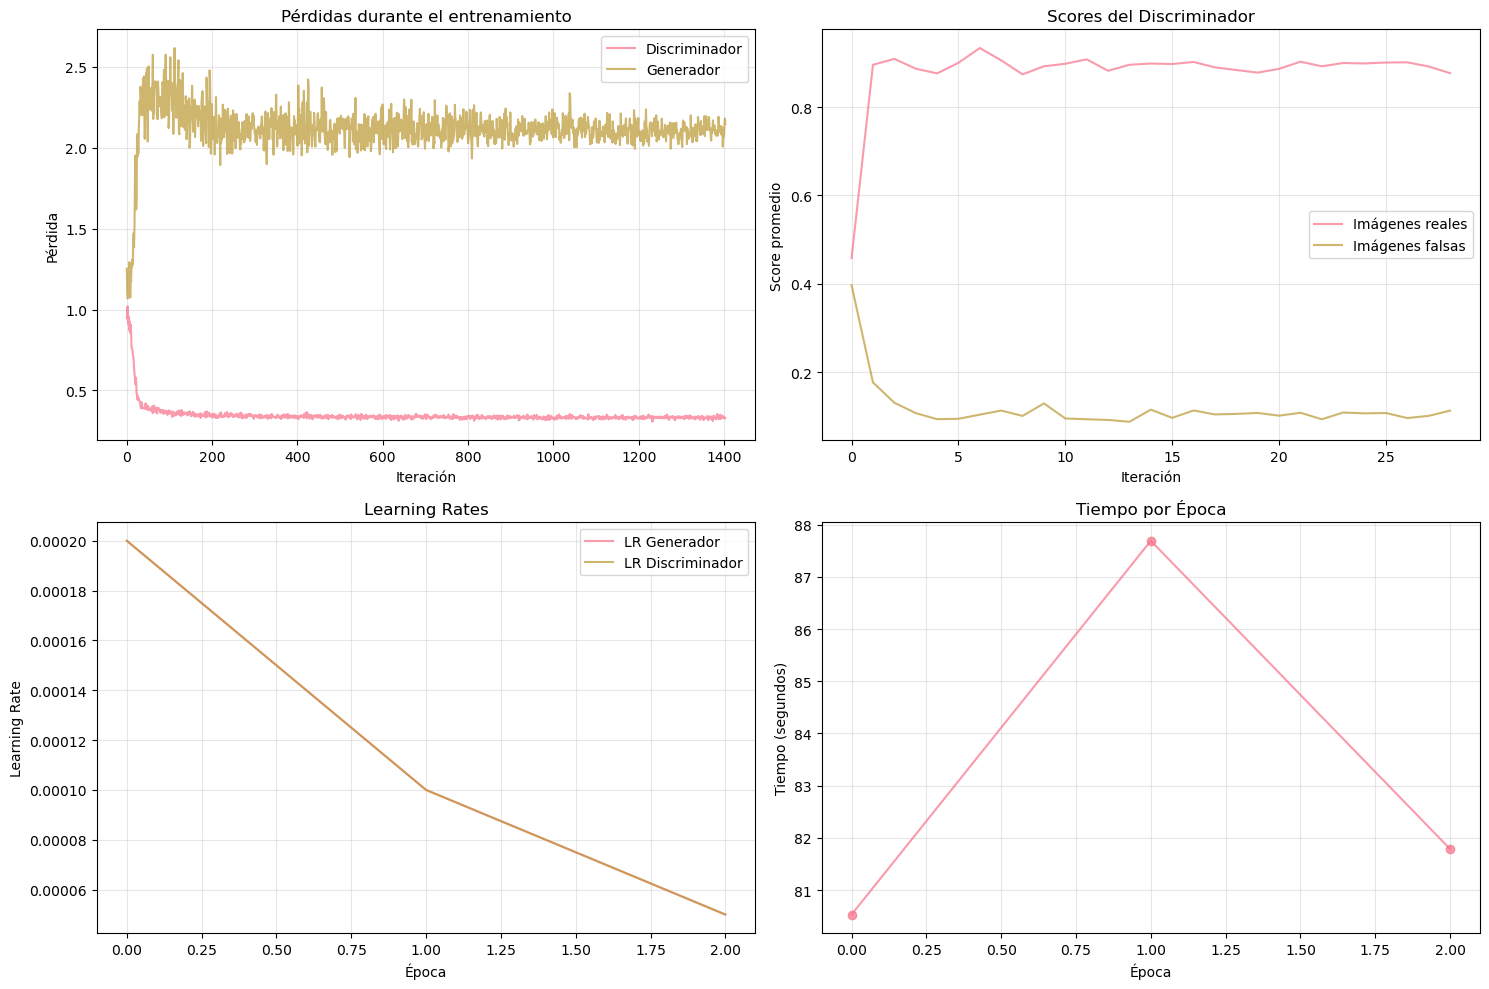


🎉 ¡Entrenamiento completado!
⏱️  Tiempo total: 275.51s (4.59 minutos)
📁 Resultados guardados en: runs\dcgan_pretrained_nb
🖼️  Muestras en: runs\dcgan_pretrained_nb\samples
💾 Checkpoints en: runs\dcgan_pretrained_nb\checkpoints
📊 Logs en: runs\dcgan_pretrained_nb\logs


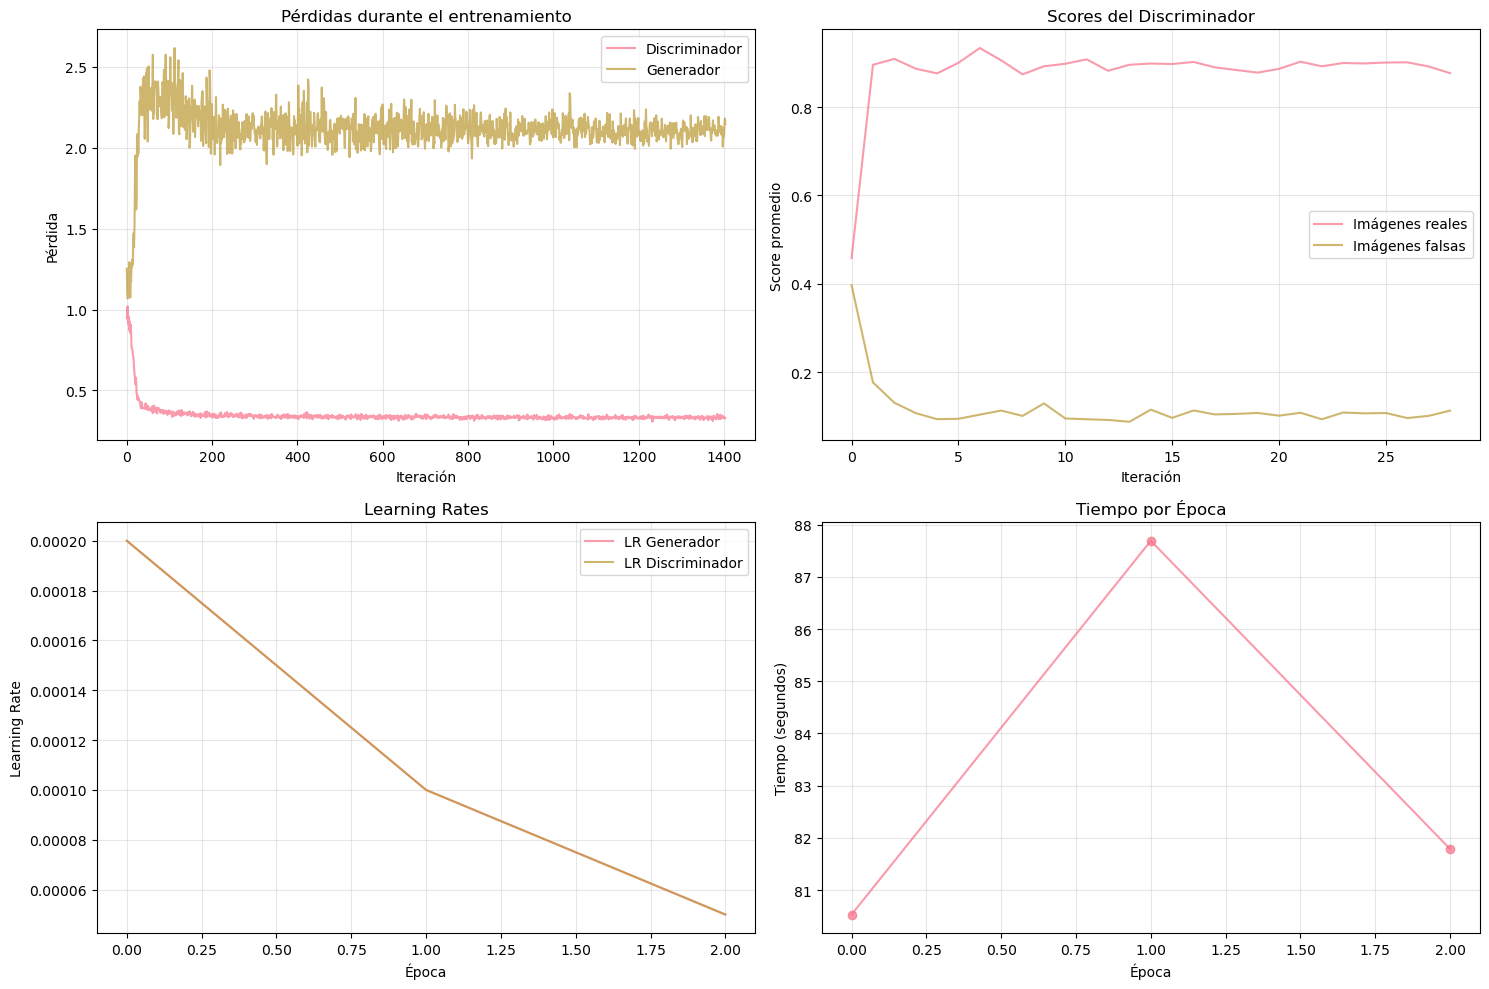

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict
import json

# Configurar semilla para reproducibilidad
set_seed(CFG["seed"])

# Inicializar modelos
print("🏗️  Inicializando modelos...")
netG = Generator(CFG["z_dim"], 3, CFG["g_channels"], CFG["image_size"]).to(device)

if CFG["disc"] == "dcgan":
    netD = DiscriminatorDCGAN(3, CFG["d_channels"], CFG["dropout_rate"]).to(device)
    print(f"🔧 Usando discriminador DCGAN clásico")
else:
    netD = DiscriminatorPretrained(
        CFG["disc"], 
        pretrained=CFG["use_pretrained"], 
        dropout_rate=CFG["dropout_rate"]
    ).to(device)
    print(f"🔧 Usando discriminador pretrained: {CFG['disc']}")

# Inicializar pesos
print("⚖️  Inicializando pesos...")
netG.apply(weights_init_dcgan)
if isinstance(netD, DiscriminatorDCGAN):
    netD.apply(weights_init_dcgan)
else:
    # Para modelos pretrained, solo inicializar el clasificador
    netD.classifier.apply(weights_init_xavier)

# Mostrar información de los modelos
print(f"\n📊 Información de modelos:")
print(f"   Generador: {count_parameters(netG):,} parámetros")
print(f"   Discriminador: {count_parameters(netD):,} parámetros")
print(f"   Total: {count_parameters(netG) + count_parameters(netD):,} parámetros")

# Configurar optimizadores y criterio
criterion = nn.BCEWithLogitsLoss()
optG = torch.optim.Adam(
    netG.parameters(), 
    lr=CFG["lr_g"], 
    betas=(CFG["beta1"], CFG["beta2"]),
    weight_decay=CFG["weight_decay"]
)
optD = torch.optim.Adam(
    netD.parameters(), 
    lr=CFG["lr_d"], 
    betas=(CFG["beta1"], CFG["beta2"]),
    weight_decay=CFG["weight_decay"]
)

# Configurar schedulers opcionales
scheduler_G = torch.optim.lr_scheduler.StepLR(optG, step_size=CFG["epochs"]//3, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optD, step_size=CFG["epochs"]//3, gamma=0.5)

# Ruido fijo para evaluación
fixed_noise = torch.randn(CFG["num_eval_samples"], CFG["z_dim"], 1, 1, device=device)

# Configurar etiquetas con suavizado
real_label_val = CFG["real_label_smoothing"] if CFG["label_smoothing"] else 1.0
fake_label_val = CFG["fake_label_smoothing"] if CFG["label_smoothing"] else 0.0

print(f"🎯 Etiquetas configuradas: real={real_label_val}, fake={fake_label_val}")

# Estructuras para logging
metrics = defaultdict(list)
training_history = {
    "losses_D": [],
    "losses_G": [],
    "scores_real": [],
    "scores_fake": [],
    "lr_G": [],
    "lr_D": [],
    "epoch_times": []
}

def save_metrics():
    """Guardar métricas en archivo JSON"""
    with open(logs_dir / "training_metrics.json", "w") as f:
        json.dump(training_history, f, indent=2)

def plot_training_progress():
    """Plotear progreso del entrenamiento"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Pérdidas
    ax1.plot(training_history["losses_D"], label="Discriminador", alpha=0.7)
    ax1.plot(training_history["losses_G"], label="Generador", alpha=0.7)
    ax1.set_title("Pérdidas durante el entrenamiento")
    ax1.set_xlabel("Iteración")
    ax1.set_ylabel("Pérdida")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Scores del discriminador
    ax2.plot(training_history["scores_real"], label="Imágenes reales", alpha=0.7)
    ax2.plot(training_history["scores_fake"], label="Imágenes falsas", alpha=0.7)
    ax2.set_title("Scores del Discriminador")
    ax2.set_xlabel("Iteración")
    ax2.set_ylabel("Score promedio")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rates
    ax3.plot(training_history["lr_G"], label="LR Generador", alpha=0.7)
    ax3.plot(training_history["lr_D"], label="LR Discriminador", alpha=0.7)
    ax3.set_title("Learning Rates")
    ax3.set_xlabel("Época")
    ax3.set_ylabel("Learning Rate")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Tiempos por época
    if training_history["epoch_times"]:
        ax4.plot(training_history["epoch_times"], marker='o', alpha=0.7)
        ax4.set_title("Tiempo por Época")
        ax4.set_xlabel("Época")
        ax4.set_ylabel("Tiempo (segundos)")
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(logs_dir / "training_progress.png", dpi=150, bbox_inches='tight')
    plt.show()

def evaluate_discriminator():
    """Evaluar discriminador en batch de prueba"""
    netD.eval()
    with torch.no_grad():
        # Tomar batch real
        real_batch = next(iter(loader))[0].to(device)
        scores_real = torch.sigmoid(netD(real_batch)).cpu().numpy()
        
        # Generar batch falso
        z = torch.randn(real_batch.size(0), CFG["z_dim"], 1, 1, device=device)
        fake_batch = netG(z)
        scores_fake = torch.sigmoid(netD(fake_batch)).cpu().numpy()
        
        return scores_real.mean(), scores_fake.mean()

print("🚀 Iniciando entrenamiento...")
print("=" * 80)

# Loop de entrenamiento principal
iteration = 0
start_time = time.time()

for epoch in range(1, CFG["epochs"] + 1):
    epoch_start = time.time()
    netG.train()
    netD.train()
    
    # Barras de progreso
    pbar = tqdm(loader, desc=f"Época {epoch}/{CFG['epochs']}", leave=False)
    epoch_losses_D = []
    epoch_losses_G = []
    
    for i, (imgs, _) in enumerate(pbar):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Agregar ruido opcional para regularización
        if CFG["noise_std"] > 0:
            imgs = add_noise(imgs, CFG["noise_std"])
        
        # =====================================
        # Entrenar Discriminador
        # =====================================
        netD.zero_grad()
        
        # Batch real
        real_labels = torch.full((batch_size,), real_label_val, device=device)
        real_labels += torch.randn_like(real_labels) * 0.05  # Ruido en etiquetas
        
        output_real = netD(imgs)
        loss_D_real = criterion(output_real, real_labels)
        
        # Batch falso
        noise = torch.randn(batch_size, CFG["z_dim"], 1, 1, device=device)
        fake_imgs = netG(noise)
        fake_labels = torch.full((batch_size,), fake_label_val, device=device)
        fake_labels += torch.randn_like(fake_labels) * 0.05  # Ruido en etiquetas
        
        output_fake = netD(fake_imgs.detach())
        loss_D_fake = criterion(output_fake, fake_labels)
        
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optD.step()
        
        # =====================================
        # Entrenar Generador
        # =====================================
        netG.zero_grad()
        
        # El generador quiere que el discriminador clasifique las falsas como reales
        output_fake_for_G = netD(fake_imgs)
        real_labels_for_G = torch.full((batch_size,), real_label_val, device=device)
        loss_G = criterion(output_fake_for_G, real_labels_for_G)
        
        loss_G.backward()
        optG.step()
        
        # Guardar métricas
        epoch_losses_D.append(loss_D.item())
        epoch_losses_G.append(loss_G.item())
        training_history["losses_D"].append(loss_D.item())
        training_history["losses_G"].append(loss_G.item())
        
        # Logging detallado
        if iteration % CFG["log_every"] == 0:
            with torch.no_grad():
                real_score = torch.sigmoid(output_real).mean().item()
                fake_score = torch.sigmoid(output_fake).mean().item()
                training_history["scores_real"].append(real_score)
                training_history["scores_fake"].append(fake_score)
            
            pbar.set_postfix({
                'D_loss': f'{loss_D.item():.4f}',
                'G_loss': f'{loss_G.item():.4f}',
                'D(x)': f'{real_score:.3f}',
                'D(G(z))': f'{fake_score:.3f}'
            })
        
        iteration += 1
    
    # Finalizar época
    epoch_time = time.time() - epoch_start
    training_history["epoch_times"].append(epoch_time)
    training_history["lr_G"].append(scheduler_G.get_last_lr()[0])
    training_history["lr_D"].append(scheduler_D.get_last_lr()[0])
    
    # Actualizar learning rates
    scheduler_G.step()
    scheduler_D.step()
    
    # Evaluación y logging
    avg_loss_D = np.mean(epoch_losses_D)
    avg_loss_G = np.mean(epoch_losses_G)
    
    print(f"\n📊 Época {epoch}/{CFG['epochs']} completada:")
    print(f"   Pérdida D: {avg_loss_D:.4f}")
    print(f"   Pérdida G: {avg_loss_G:.4f}")
    print(f"   Tiempo: {epoch_time:.2f}s")
    
    # Evaluación del discriminador
    if epoch % CFG["eval_every"] == 0:
        real_score_avg, fake_score_avg = evaluate_discriminator()
        print(f"   Score D(real): {real_score_avg:.3f}")
        print(f"   Score D(fake): {fake_score_avg:.3f}")
    
    # Generar y guardar muestras
    with torch.no_grad():
        netG.eval()
        fake_samples = netG(fixed_noise).cpu()
        grid = denorm(fake_samples)
        
        # Guardar imagen
        vutils.save_image(
            grid, 
            samples_dir / f"epoch_{epoch:03d}.png", 
            nrow=8, 
            padding=2
        )
        
        # Mostrar muestras durante entrenamiento
        if CFG["show_samples_during_training"] and epoch % CFG["eval_every"] == 0:
            plt.figure(figsize=(12, 12))
            plt.imshow(vutils.make_grid(grid, nrow=8, padding=2).permute(1, 2, 0))
            plt.title(f"Muestras generadas - Época {epoch}")
            plt.axis('off')
            plt.show()
    
    # Guardar checkpoint
    if epoch % CFG["save_every"] == 0:
        checkpoint = {
            "epoch": epoch,
            "netG_state_dict": netG.state_dict(),
            "netD_state_dict": netD.state_dict(),
            "optG_state_dict": optG.state_dict(),
            "optD_state_dict": optD.state_dict(),
            "config": CFG,
            "training_history": training_history
        }
        torch.save(checkpoint, checkpoints_dir / f"checkpoint_epoch_{epoch:03d}.pt")
        print(f"💾 Checkpoint guardado: epoch_{epoch:03d}.pt")
    
    # Guardar métricas
    save_metrics()
    
    # Plotear progreso cada cierto número de épocas
    if CFG["plot_losses"] and epoch % CFG["eval_every"] == 0:
        plot_training_progress()

# Entrenamiento completado
total_time = time.time() - start_time
print("\n" + "=" * 80)
print("🎉 ¡Entrenamiento completado!")
print(f"⏱️  Tiempo total: {total_time:.2f}s ({total_time/60:.2f} minutos)")
print(f"📁 Resultados guardados en: {output_dir}")
print(f"🖼️  Muestras en: {samples_dir}")
print(f"💾 Checkpoints en: {checkpoints_dir}")
print(f"📊 Logs en: {logs_dir}")

# Plotear resultado final
plot_training_progress()

## Visualización de muestras

In [ ]:
from IPython.display import Image, display
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

def show_training_evolution():
    """Mostrar evolución del entrenamiento a través de las épocas"""
    samples_dir = Path(CFG["out_dir"]) / "samples"
    image_files = sorted(samples_dir.glob("epoch_*.png"))
    
    if not image_files:
        print("❌ No se encontraron imágenes generadas")
        return
    
    print(f"🎬 Evolución del entrenamiento ({len(image_files)} épocas)")
    
    # Mostrar algunas épocas clave
    key_epochs = [0, len(image_files)//4, len(image_files)//2, 3*len(image_files)//4, -1]
    key_epochs = [i for i in key_epochs if i < len(image_files)]
    
    fig, axes = plt.subplots(1, len(key_epochs), figsize=(20, 4))
    if len(key_epochs) == 1:
        axes = [axes]
    
    for i, epoch_idx in enumerate(key_epochs):
        img_path = image_files[epoch_idx]
        img = plt.imread(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Época {epoch_idx + 1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar la imagen final más grande
    print("\n🖼️  Resultado final:")
    final_img = plt.imread(image_files[-1])
    plt.figure(figsize=(12, 12))
    plt.imshow(final_img)
    plt.title(f'Muestras finales - Época {len(image_files)}', fontsize=16)
    plt.axis('off')
    plt.show()

def analyze_generated_samples():
    """Análisis avanzado de las muestras generadas"""
    print("🔬 Análisis de muestras generadas vs. reales")
    
    # Generar muestras para análisis
    netG.eval()
    with torch.no_grad():
        # Muestras generadas
        z = torch.randn(100, CFG["z_dim"], 1, 1, device=device)
        generated_samples = netG(z).cpu()
        
        # Muestras reales del dataset
        real_samples = []
        for i, (imgs, _) in enumerate(loader):
            real_samples.append(imgs)
            if len(real_samples) * CFG["batch_size"] >= 100:
                break
        real_samples = torch.cat(real_samples, dim=0)[:100]
    
    # Visualización comparativa
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Muestras reales
    real_grid = vutils.make_grid(real_samples[:64], nrow=8, padding=2, normalize=True)
    ax1.imshow(real_grid.permute(1, 2, 0))
    ax1.set_title('Muestras Reales del Dataset', fontsize=16)
    ax1.axis('off')
    
    # Muestras generadas
    gen_grid = vutils.make_grid(denorm(generated_samples[:64]), nrow=8, padding=2)
    ax2.imshow(gen_grid.permute(1, 2, 0))
    ax2.set_title('Muestras Generadas por el Modelo', fontsize=16)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return generated_samples, real_samples

def analyze_latent_space():
    """Análisis del espacio latente"""
    print("🌌 Análisis del espacio latente")
    
    netG.eval()
    with torch.no_grad():
        # Interpolación lineal en el espacio latente
        z1 = torch.randn(1, CFG["z_dim"], 1, 1, device=device)
        z2 = torch.randn(1, CFG["z_dim"], 1, 1, device=device)
        
        # Crear interpolaciones
        alphas = torch.linspace(0, 1, 10)
        interpolations = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            img = netG(z_interp).cpu()
            interpolations.append(img)
        
        interpolations = torch.cat(interpolations, dim=0)
    
    # Visualizar interpolación
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        img = denorm(interpolations[i]).permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'α={alphas[i]:.1f}')
        axes[i].axis('off')
    
    plt.suptitle('Interpolación Linear en el Espacio Latente', fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_fid_approximation(real_samples, generated_samples):
    """Aproximación simple de FID usando características básicas"""
    print("📊 Calculando aproximación de métricas de calidad...")
    
    # Convertir a numpy y calcular estadísticas básicas
    real_np = real_samples.numpy()
    gen_np = generated_samples.detach().numpy()
    
    # Estadísticas por canal
    real_stats = {
        'mean': real_np.mean(axis=(0, 2, 3)),
        'std': real_np.std(axis=(0, 2, 3)),
        'min': real_np.min(axis=(0, 2, 3)),
        'max': real_np.max(axis=(0, 2, 3))
    }
    
    gen_stats = {
        'mean': gen_np.mean(axis=(0, 2, 3)),
        'std': gen_np.std(axis=(0, 2, 3)),
        'min': gen_np.min(axis=(0, 2, 3)),
        'max': gen_np.max(axis=(0, 2, 3))
    }
    
    # Comparación visual de estadísticas
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    channels = ['R', 'G', 'B']
    
    for i, stat in enumerate(['mean', 'std']):
        ax = axes[0, i]
        x = np.arange(3)
        width = 0.35
        
        ax.bar(x - width/2, real_stats[stat], width, label='Real', alpha=0.7)
        ax.bar(x + width/2, gen_stats[stat], width, label='Generado', alpha=0.7)
        
        ax.set_xlabel('Canal')
        ax.set_ylabel(stat.capitalize())
        ax.set_title(f'{stat.capitalize()} por Canal')
        ax.set_xticks(x)
        ax.set_xticklabels(channels)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Histogramas de distribución
    for i, channel in enumerate(range(3)):
        ax = axes[1, i] if i < 2 else None
        if ax is None:
            continue
            
        ax.hist(real_np[:, channel].flatten(), bins=50, alpha=0.7, label='Real', density=True)
        ax.hist(gen_np[:, channel].flatten(), bins=50, alpha=0.7, label='Generado', density=True)
        ax.set_xlabel('Valor del pixel')
        ax.set_ylabel('Densidad')
        ax.set_title(f'Distribución Canal {channels[channel]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Métricas numéricas
    print("\n📈 Métricas de comparación:")
    for stat in ['mean', 'std']:
        diff = np.abs(real_stats[stat] - gen_stats[stat])
        print(f"   Diferencia en {stat}: {diff.mean():.4f} ± {diff.std():.4f}")

def generate_diverse_samples():
    """Generar muestras diversas del modelo entrenado"""
    print("🎨 Generando muestras diversas...")
    
    netG.eval()
    with torch.no_grad():
        # Generar múltiples batches
        all_samples = []
        for _ in range(5):  # 5 batches de 16 = 80 muestras
            z = torch.randn(16, CFG["z_dim"], 1, 1, device=device)
            samples = netG(z).cpu()
            all_samples.append(samples)
        
        all_samples = torch.cat(all_samples, dim=0)
    
    # Mostrar grid grande de muestras
    grid = vutils.make_grid(denorm(all_samples), nrow=10, padding=2)
    
    plt.figure(figsize=(20, 16))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Colección de Muestras Generadas', fontsize=20)
    plt.axis('off')
    
    # Guardar imagen de alta calidad
    plt.savefig(samples_dir / "diverse_samples_collection.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"💾 Colección guardada en: {samples_dir / 'diverse_samples_collection.png'}")

# Ejecutar todas las visualizaciones y análisis
print("🎭 Iniciando análisis completo de resultados...")
print("=" * 60)

# 1. Mostrar evolución del entrenamiento
show_training_evolution()

# 2. Análisis de muestras generadas vs reales
generated_samples, real_samples = analyze_generated_samples()

# 3. Análisis del espacio latente
analyze_latent_space()

# 4. Métricas de calidad
calculate_fid_approximation(real_samples, generated_samples)

# 5. Generar colección de muestras diversas
generate_diverse_samples()

print("\n" + "=" * 60)
print("✅ Análisis completo finalizado!")
print(f"📁 Todos los archivos están en: {output_dir}")

# Mostrar resumen final
print(f"\n📋 Resumen del experimento:")
print(f"   Dataset: {CFG['dataset']}")
print(f"   Discriminador: {CFG['disc']}")
print(f"   Épocas entrenadas: {CFG['epochs']}")
print(f"   Pesos pretrained: {CFG['use_pretrained']}")
print(f"   Batch size: {CFG['batch_size']}")
print(f"   Learning rates: G={CFG['lr_g']}, D={CFG['lr_d']}")

# Mostrar la imagen final una vez más
final_samples_path = samples_dir / f"epoch_{CFG['epochs']:03d}.png"
if final_samples_path.exists():
    print(f"\n🏆 Resultado final:")
    display(Image(filename=str(final_samples_path)))

## Experimentación Post-Entrenamiento

Funciones útiles para cargar modelos entrenados y experimentar con diferentes configuraciones.

In [ ]:
def load_checkpoint(checkpoint_path, netG, netD, optG=None, optD=None):
    """Cargar checkpoint guardado"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    
    if optG is not None and 'optG_state_dict' in checkpoint:
        optG.load_state_dict(checkpoint['optG_state_dict'])
    if optD is not None and 'optD_state_dict' in checkpoint:
        optD.load_state_dict(checkpoint['optD_state_dict'])
    
    epoch = checkpoint.get('epoch', 0)
    config = checkpoint.get('config', {})
    
    print(f"✅ Checkpoint cargado desde época {epoch}")
    return epoch, config

def experiment_with_different_discriminators():
    """Experimentar con diferentes discriminadores"""
    discriminators = ["dcgan", "resnet18", "mobilenet_v2", "efficientnet_b0"]
    
    print("🧪 Comparando diferentes discriminadores...")
    
    results = {}
    
    for disc_name in discriminators:
        print(f"\n🔧 Probando discriminador: {disc_name}")
        
        # Crear generador
        test_netG = Generator(CFG["z_dim"], 3, CFG["g_channels"], CFG["image_size"]).to(device)
        test_netG.apply(weights_init_dcgan)
        
        # Crear discriminador
        if disc_name == "dcgan":
            test_netD = DiscriminatorDCGAN(3, CFG["d_channels"], CFG["dropout_rate"]).to(device)
            test_netD.apply(weights_init_dcgan)
        else:
            test_netD = DiscriminatorPretrained(disc_name, pretrained=True, dropout_rate=CFG["dropout_rate"]).to(device)
        
        # Contar parámetros
        g_params = count_parameters(test_netG)
        d_params = count_parameters(test_netD)
        
        results[disc_name] = {
            'generator_params': g_params,
            'discriminator_params': d_params,
            'total_params': g_params + d_params
        }
        
        print(f"   Parámetros G: {g_params:,}")
        print(f"   Parámetros D: {d_params:,}")
        print(f"   Total: {g_params + d_params:,}")
    
    # Visualizar comparación
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    disc_names = list(results.keys())
    g_params = [results[disc]['generator_params'] for disc in disc_names]
    d_params = [results[disc]['discriminator_params'] for disc in disc_names]
    
    # Gráfico de barras
    x = np.arange(len(disc_names))
    width = 0.35
    
    ax1.bar(x - width/2, g_params, width, label='Generador', alpha=0.8)
    ax1.bar(x + width/2, d_params, width, label='Discriminador', alpha=0.8)
    
    ax1.set_xlabel('Tipo de Discriminador')
    ax1.set_ylabel('Número de Parámetros')
    ax1.set_title('Comparación de Parámetros por Modelo')
    ax1.set_xticks(x)
    ax1.set_xticklabels(disc_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de pastel para parámetros totales
    total_params = [results[disc]['total_params'] for disc in disc_names]
    ax2.pie(total_params, labels=disc_names, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Distribución de Parámetros Totales')
    
    plt.tight_layout()
    plt.show()
    
    return results

def generate_interpolation_video_frames():
    """Generar frames para un video de interpolación"""
    print("🎬 Generando frames para video de interpolación...")
    
    netG.eval()
    video_dir = output_dir / "video_frames"
    video_dir.mkdir(exist_ok=True)
    
    with torch.no_grad():
        # Crear ruido inicial y final
        z_start = torch.randn(1, CFG["z_dim"], 1, 1, device=device)
        z_end = torch.randn(1, CFG["z_dim"], 1, 1, device=device)
        
        # Crear 60 frames de interpolación (2 segundos a 30fps)
        num_frames = 60
        alphas = torch.linspace(0, 1, num_frames)
        
        for i, alpha in enumerate(alphas):
            z_interp = alpha * z_end + (1 - alpha) * z_start
            img = netG(z_interp).cpu()
            img_denorm = denorm(img)
            
            # Guardar frame
            vutils.save_image(
                img_denorm, 
                video_dir / f"frame_{i:03d}.png",
                normalize=False
            )
        
        print(f"💾 {num_frames} frames guardados en: {video_dir}")
        print("💡 Tip: Usa ffmpeg para crear video:")
        print(f"   ffmpeg -r 30 -i {video_dir}/frame_%03d.png -vcodec libx264 -pix_fmt yuv420p interpolation.mp4")

def test_model_robustness():
    """Probar robustez del modelo con diferentes inputs"""
    print("🛡️  Probando robustez del modelo...")
    
    netG.eval()
    
    # Test 1: Diferentes escalas de ruido
    print("\n1. Probando diferentes escalas de ruido:")
    noise_scales = [0.5, 1.0, 1.5, 2.0]
    
    fig, axes = plt.subplots(1, len(noise_scales), figsize=(16, 4))
    
    for i, scale in enumerate(noise_scales):
        with torch.no_grad():
            z = torch.randn(1, CFG["z_dim"], 1, 1, device=device) * scale
            img = netG(z).cpu()
            img_denorm = denorm(img)
        
        axes[i].imshow(img_denorm.squeeze().permute(1, 2, 0))
        axes[i].set_title(f'Escala: {scale}')
        axes[i].axis('off')
    
    plt.suptitle('Robustez a Diferentes Escalas de Ruido')
    plt.tight_layout()
    plt.show()
    
    # Test 2: Ruido con diferentes distribuciones
    print("\n2. Probando diferentes distribuciones de ruido:")
    distributions = ['normal', 'uniform', 'laplace']
    
    fig, axes = plt.subplots(1, len(distributions), figsize=(12, 4))
    
    for i, dist in enumerate(distributions):
        with torch.no_grad():
            if dist == 'normal':
                z = torch.randn(1, CFG["z_dim"], 1, 1, device=device)
            elif dist == 'uniform':
                z = torch.rand(1, CFG["z_dim"], 1, 1, device=device) * 2 - 1  # [-1, 1]
            elif dist == 'laplace':
                z = torch.distributions.Laplace(0, 1).sample((1, CFG["z_dim"], 1, 1)).to(device)
            
            img = netG(z).cpu()
            img_denorm = denorm(img)
        
        axes[i].imshow(img_denorm.squeeze().permute(1, 2, 0))
        axes[i].set_title(f'Distribución: {dist}')
        axes[i].axis('off')
    
    plt.suptitle('Robustez a Diferentes Distribuciones de Ruido')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso de las funciones

print("🔧 Funciones de experimentación disponibles:")
print("1. load_checkpoint(path, netG, netD) - Cargar modelo entrenado")
print("2. experiment_with_different_discriminators() - Comparar discriminadores") 
print("3. generate_interpolation_video_frames() - Crear frames para video")
print("4. test_model_robustness() - Probar robustez del modelo")
print("\n💡 Ejecuta cualquiera de estas funciones para experimentar!")

# Ejecutar comparación de discriminadores
print("\n🚀 Ejecutando comparación de discriminadores...")
disc_comparison = experiment_with_different_discriminators()

# Probar robustez si hay un modelo entrenado
if 'netG' in globals() and netG is not None:
    print("\n🚀 Probando robustez del modelo...")
    test_model_robustness()
    
    print("\n🚀 Generando frames de interpolación...")
    generate_interpolation_video_frames()
else:
    print("\n⚠️  No hay modelo entrenado cargado. Entrena primero o carga un checkpoint.")